In [1]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics



def printmd(string):
    display(Markdown(string))
    
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


%matplotlib inline

In [2]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational.num','marital.status', 'occupation', 'relationship', 'race', 'gender','capital.gain', 'capital.loss', 'hours.per.week', 'native.country','income']

train = pd.read_csv('adult_data.csv', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.csv', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')


adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

In [3]:
# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
printmd('## 1.1. Columns and their types')
print(adult.info())

## 1.1. Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational.num  48842 non-null  int64   
 5   marital.status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital.gain     48842 non-null  int64   
 11  capital.loss     48842 non-null  int64   
 12  hours.per.week   48842 non-null  int64   
 13  native.country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


In [4]:
# Top 5 records
printmd('## 1.2. Data')
print(adult.head(5))

print('\n')

printmd('## 1.3. Summary Statistics')
adult.describe()

## 1.2. Data

   age  workclass  fnlwgt     education  educational.num      marital.status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital.gain  capital.loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours.per.week native.country incom

## 1.3. Summary Statistics

,age,fnlwgt,educational.num,capital.gain,capital.loss,hours.per.week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
printmd('## 1.4. Missing values')
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')

## 1.4. Missing values

workclass: 2799 records

occupation: 2809 records

native.country: 857 records

In [6]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [7]:
printmd('### 1.4.1. Filling in missing values for Attribute workclass')

test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

### 1.4.1. Filling in missing values for Attribute workclass

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Private             35960
Self-emp-not-inc     3878
Local-gov            3137
State-gov            1981
Self-emp-inc         1695
Federal-gov          1435
Never-worked          735
Without-pay            21
?                       0
Name: workclass, dtype: int64
['Private', 'Local-gov', 'Never-worked', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay']
Categories (9, object): ['?', 'Federal-gov', 'Local-gov', 'Never-worked', ..., 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']


In [8]:
printmd('### 1.4.2. Filling in missing values for Occupation occupation')

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

### 1.4.2. Filling in missing values for Occupation occupation

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prof-specialty       7725
Craft-repair         6643
Exec-managerial      6137
Adm-clerical         5845
Sales                5588
Other-service        5128
Machine-op-inspct    3067
Transport-moving     2385
Handlers-cleaners    2095
Farming-fishing      1513
Tech-support         1461
Protective-serv       988
Priv-house-serv       252
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Adm-clerical', 'Other-service', ..., 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']
Length: 14
Categories (15, object): ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', ..., 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']


In [9]:
printmd('### 1.4.3. Filling in missing values for Native Country')

test_data = adult[(adult['native.country'].values == '?')].copy()
test_label = test_data['native.country']

train_data = adult[(adult['native.country'].values != '?')].copy()
train_label = train_data['native.country']

test_data.drop(columns = ['native.country'], inplace = True)
train_data.drop(columns = ['native.country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult['native.country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native.country'].values == '?'),'native.country'] = overall_pred.values
print(adult['native.country'].value_counts())
print(adult['native.country'].unique())

### 1.4.3. Filling in missing values for Native Country

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


United-States                 44637
Mexico                          961
Philippines                     304
Germany                         206
Puerto-Rico                     184
Canada                          182
India                           160
El-Salvador                     155
Cuba                            138
England                         127
China                           127
South                           124
Jamaica                         107
Italy                           105
Dominican-Republic              103
Japan                            95
Guatemala                        89
Poland                           87
Vietnam                          87
Columbia                         86
Haiti                            75
Portugal                         67
Taiwan                           66
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

In [10]:
# Resetting the categories
adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native.country'] = adult['native.country'].cat.remove_categories('?')

In [11]:
printmd('## 1.5. Correlation Matrix')

display(adult.corr())

printmd('We see that none of the columns are highly correlated.')

## 1.5. Correlation Matrix

,age,fnlwgt,educational.num,capital.gain,capital.loss,hours.per.week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational.num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital.gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital.loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours.per.week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.

In [12]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in adult[['educational.num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1. Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.

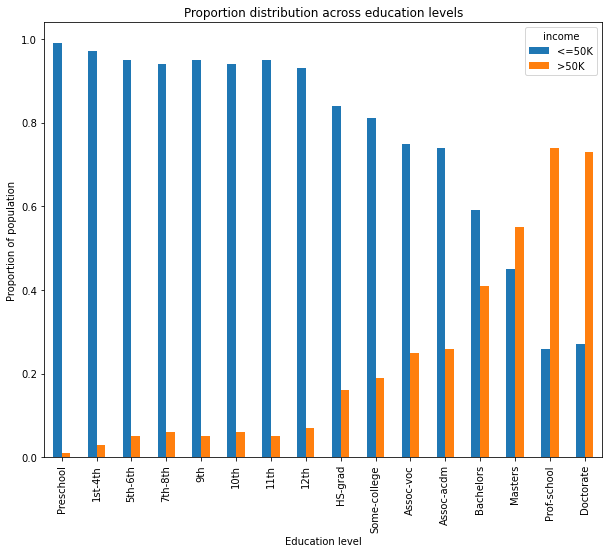

In [13]:
printmd('## 2.1. Education vs Income')

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')

## 2.2 Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         

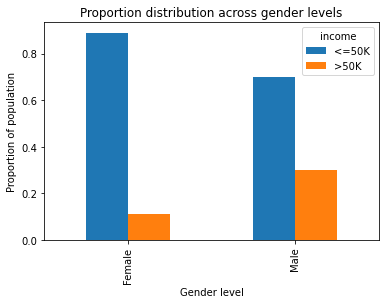

In [14]:
printmd('## 2.2 Gender vs Income')

gender = round(pd.crosstab(adult.gender, adult.income).div(pd.crosstab(adult.gender, adult.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)
ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.

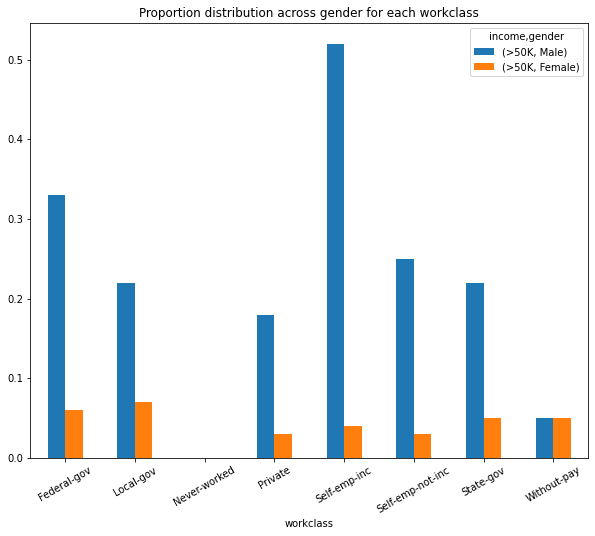

In [15]:

gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.gender]).div(pd.crosstab(adult.workclass, [adult.income, adult.gender]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

## 2.3. Occupation vs Income

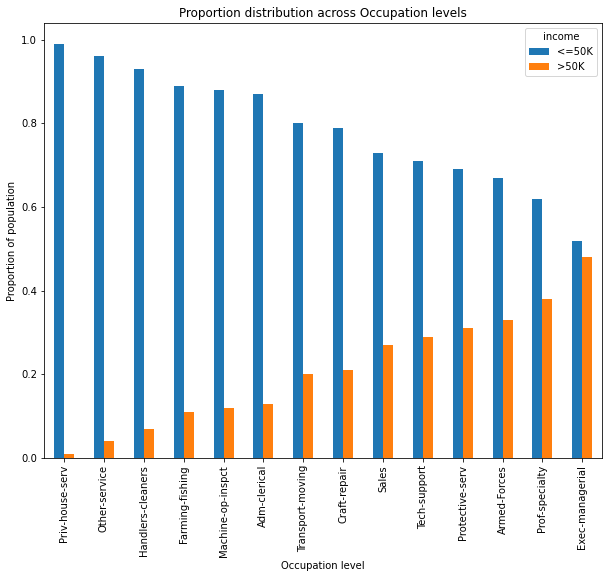

In [16]:

printmd('## 2.3. Occupation vs Income')

occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

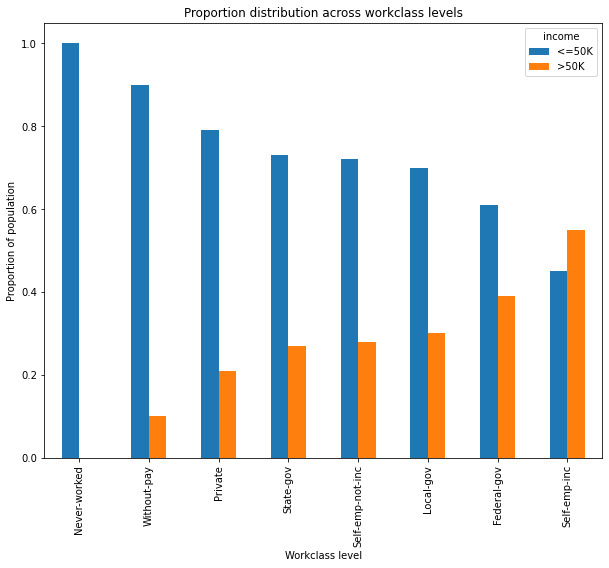

In [17]:
printmd('## 2.4. Workclass vs Income')

workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

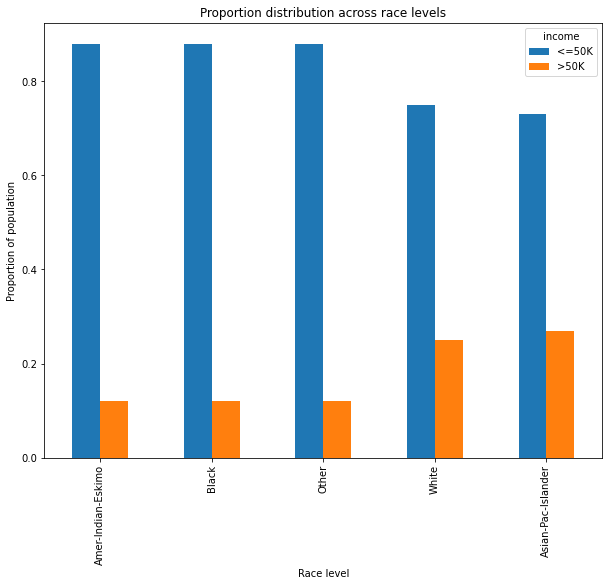

In [18]:
printmd('## 2.5. Race vs Income')

race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

## 2.6. Native Country

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.

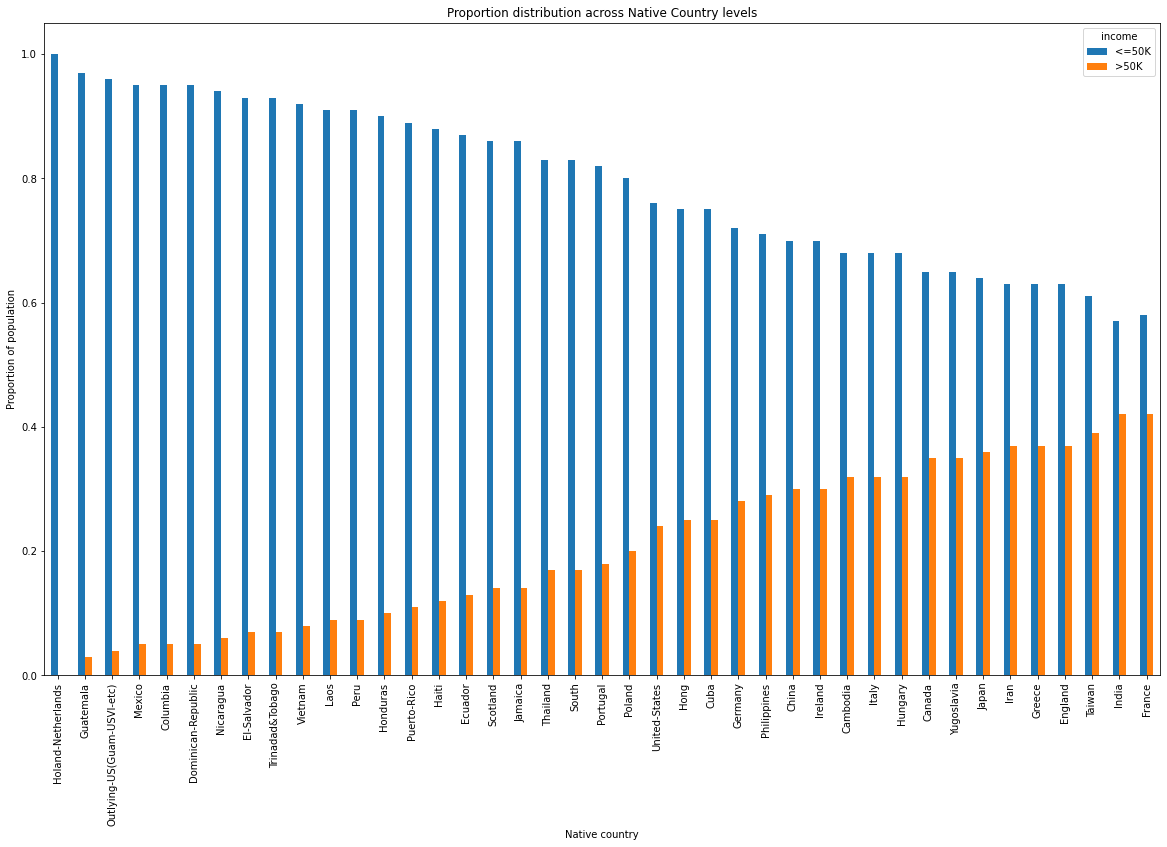

In [19]:

printmd('## 2.6. Native Country')

native_country = round(pd.crosstab(adult['native.country'], adult.income).div(pd.crosstab(adult['native.country'], adult.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)
ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')

## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 

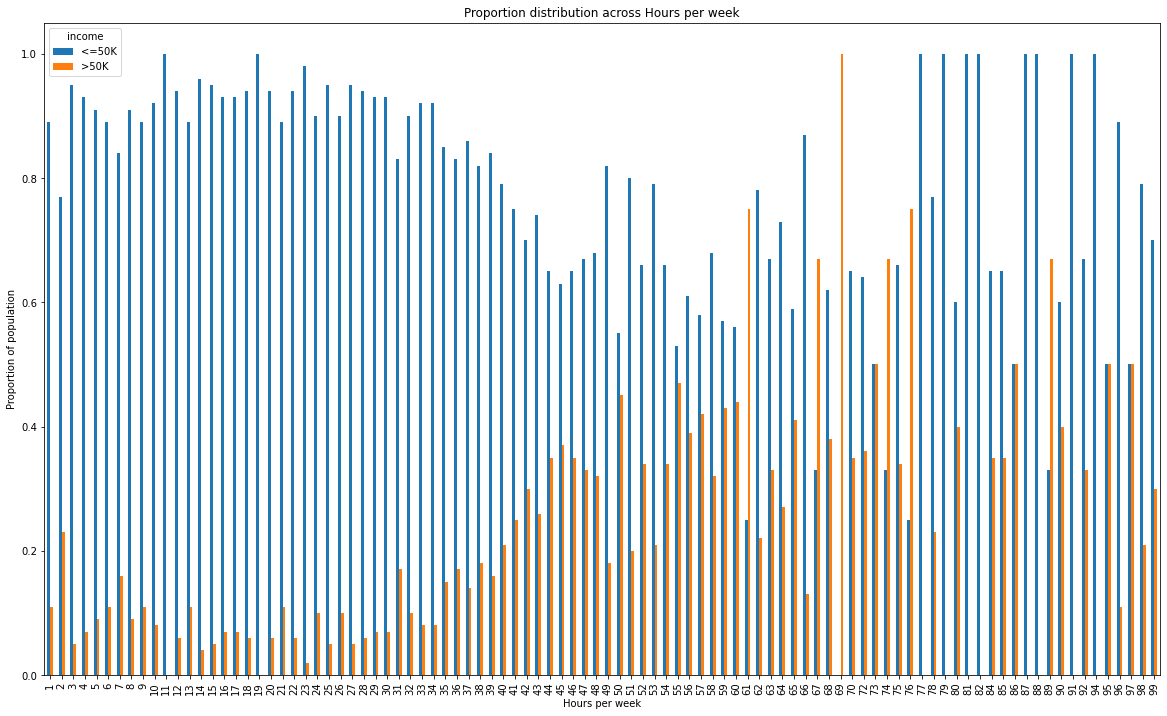

In [20]:
printmd('## 2.7. Hours per week vs Income')

hours_per_week = round(pd.crosstab(adult['hours.per.week'], adult.income).div(pd.crosstab(adult['hours.per.week'], adult.income).apply(sum,1),0),2)
# hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')

### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.

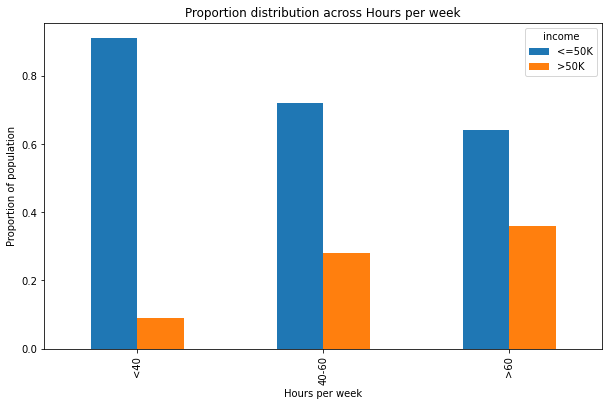

In [21]:
printmd('### 2.7.1 Hours per week with categories')

adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours.per.week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum,1),0),2)

hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')

### 2.7.2 Hours worked across working classes

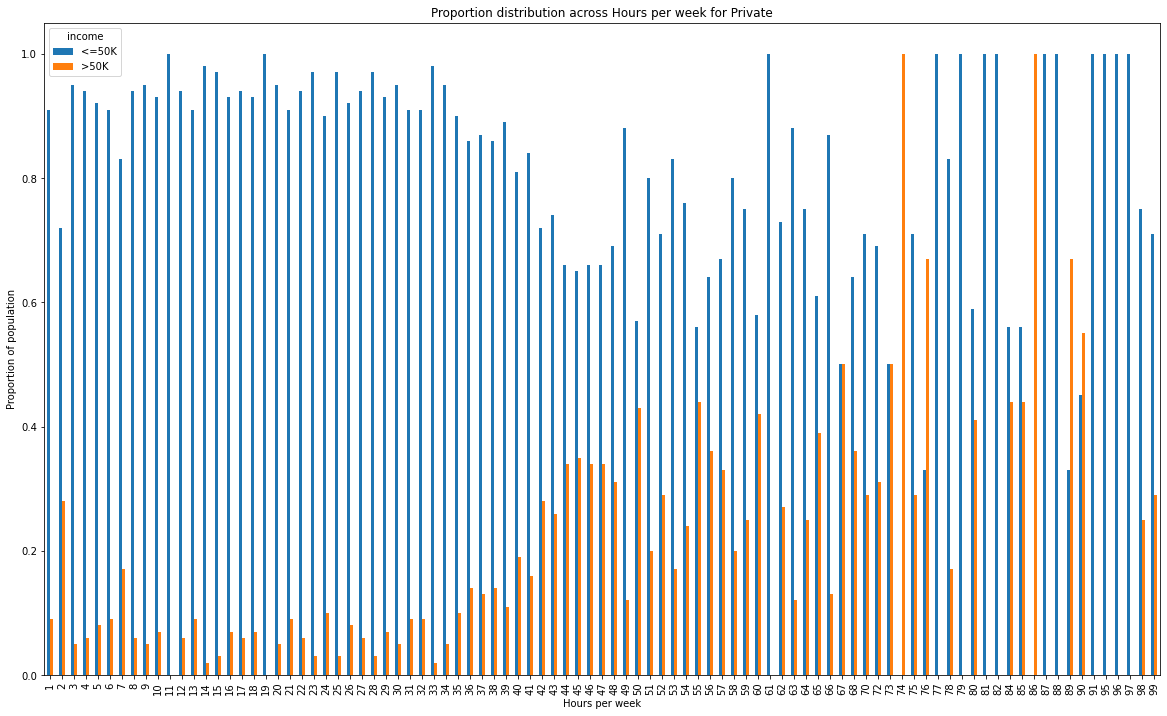

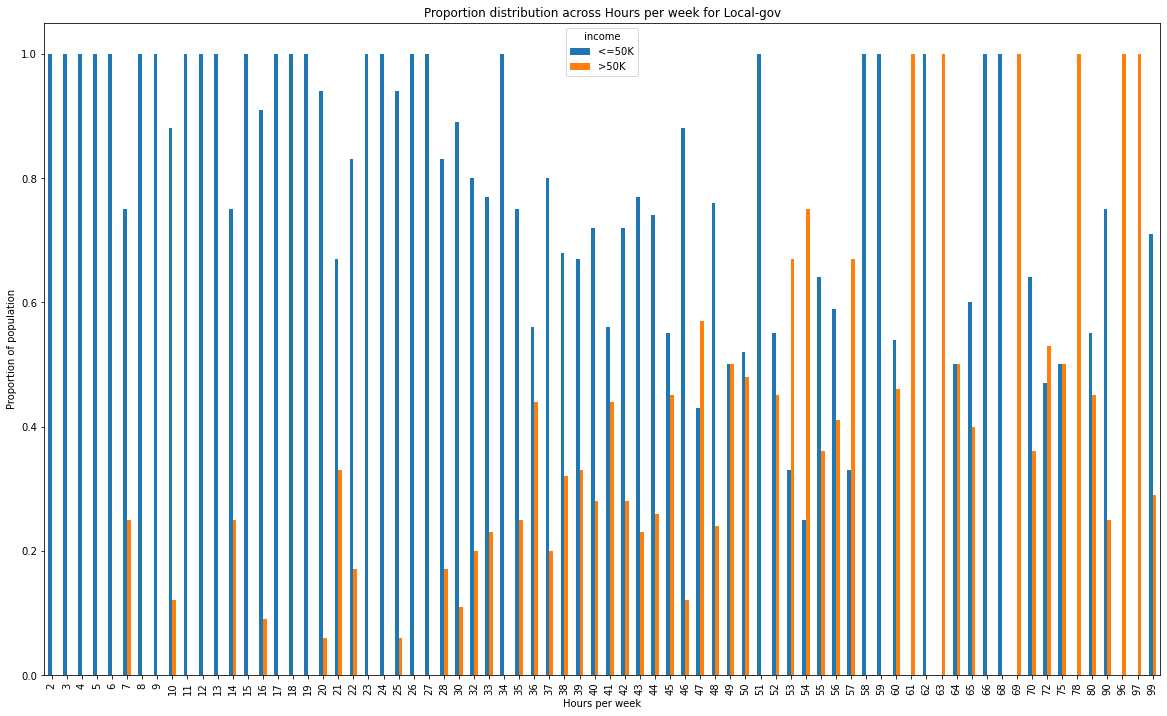

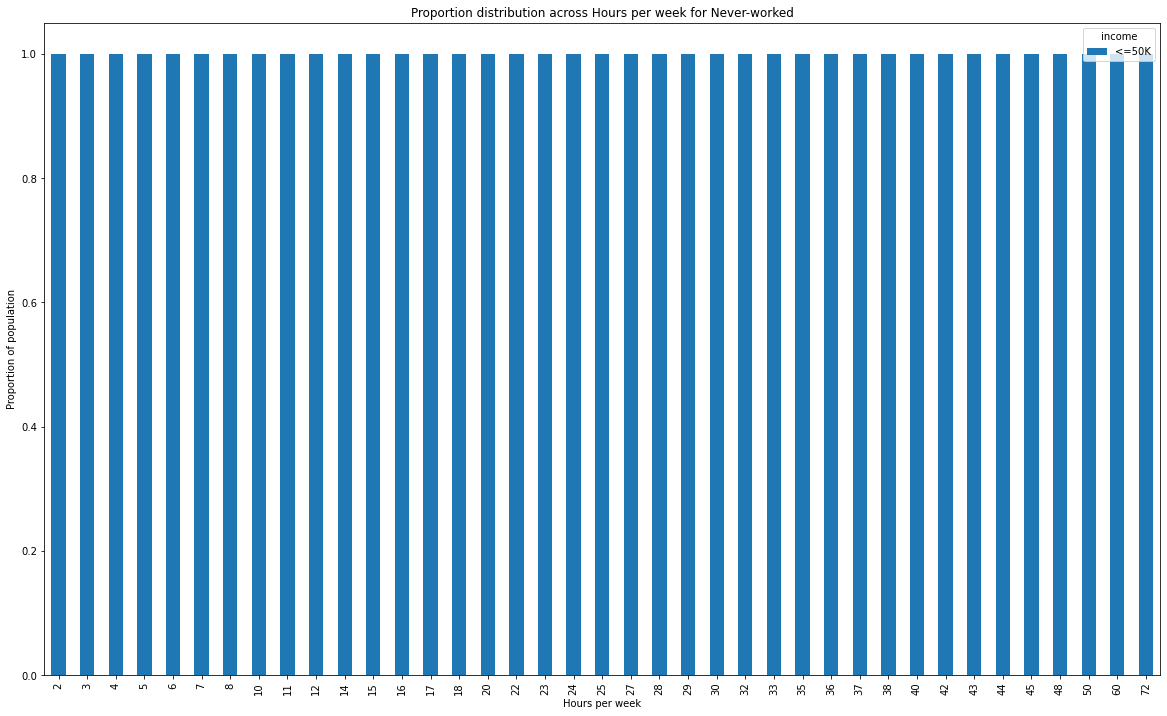

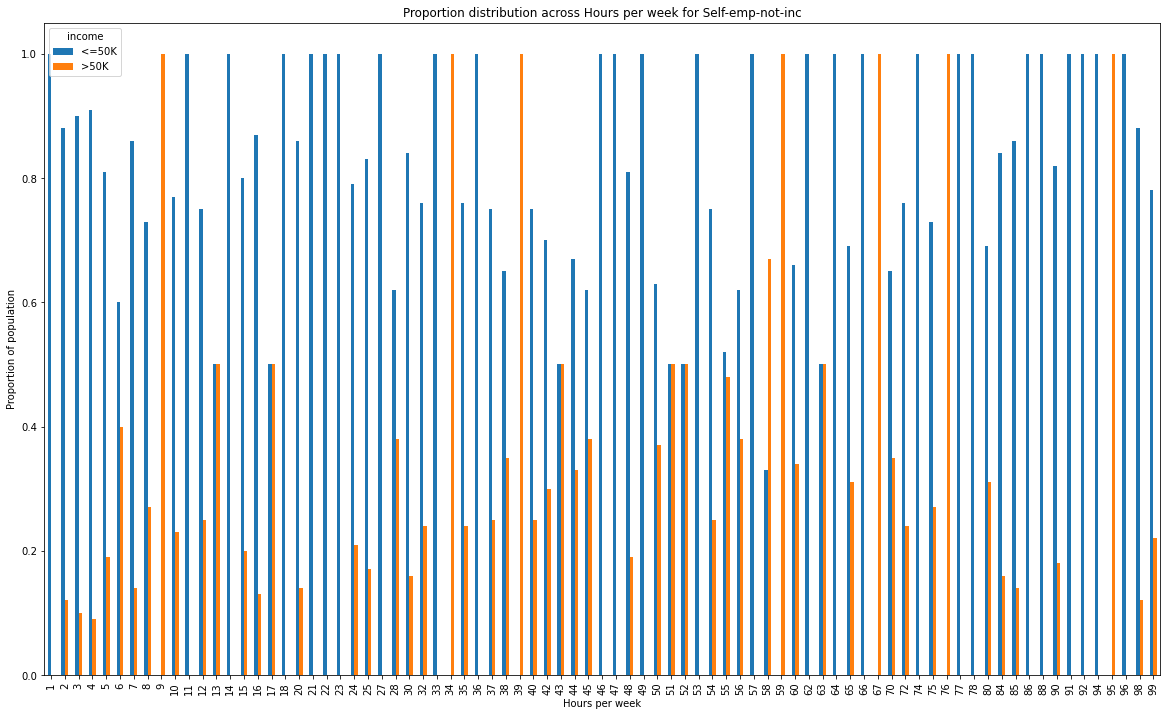

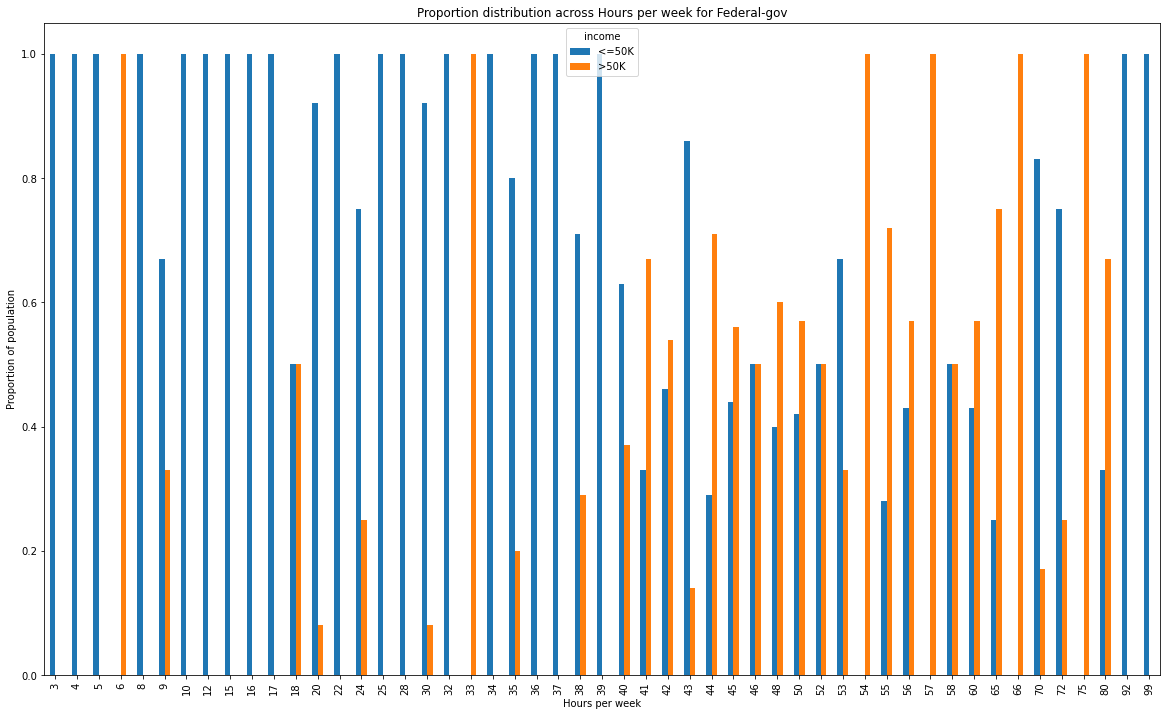

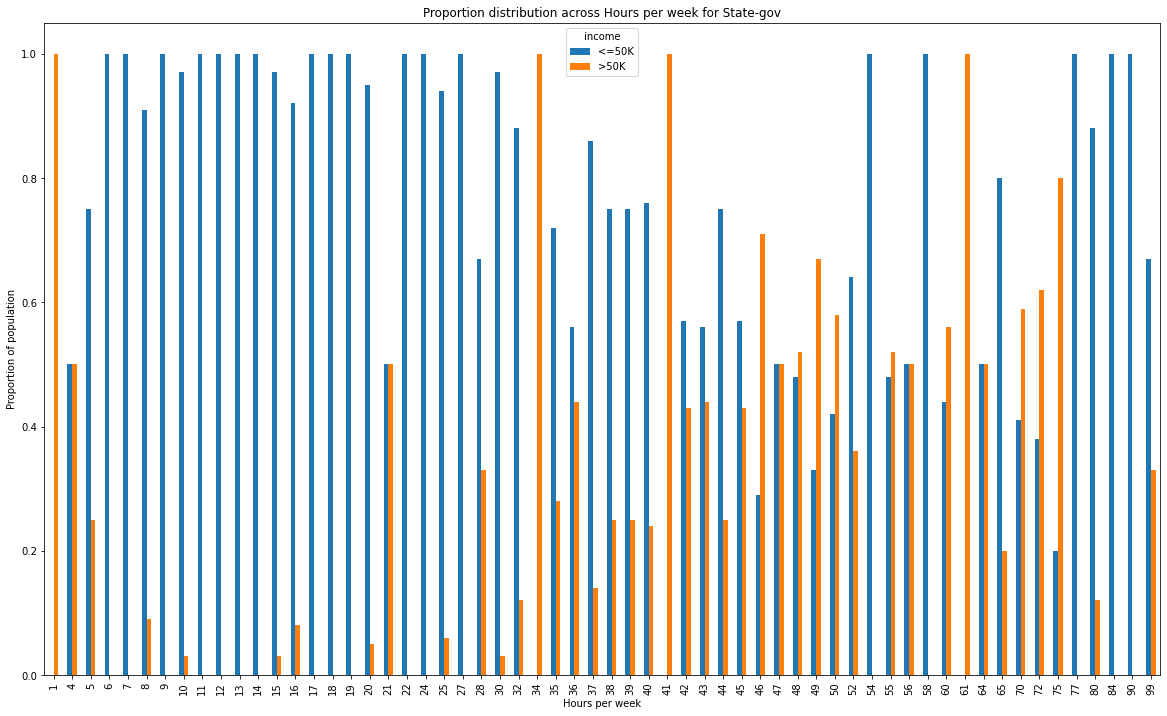

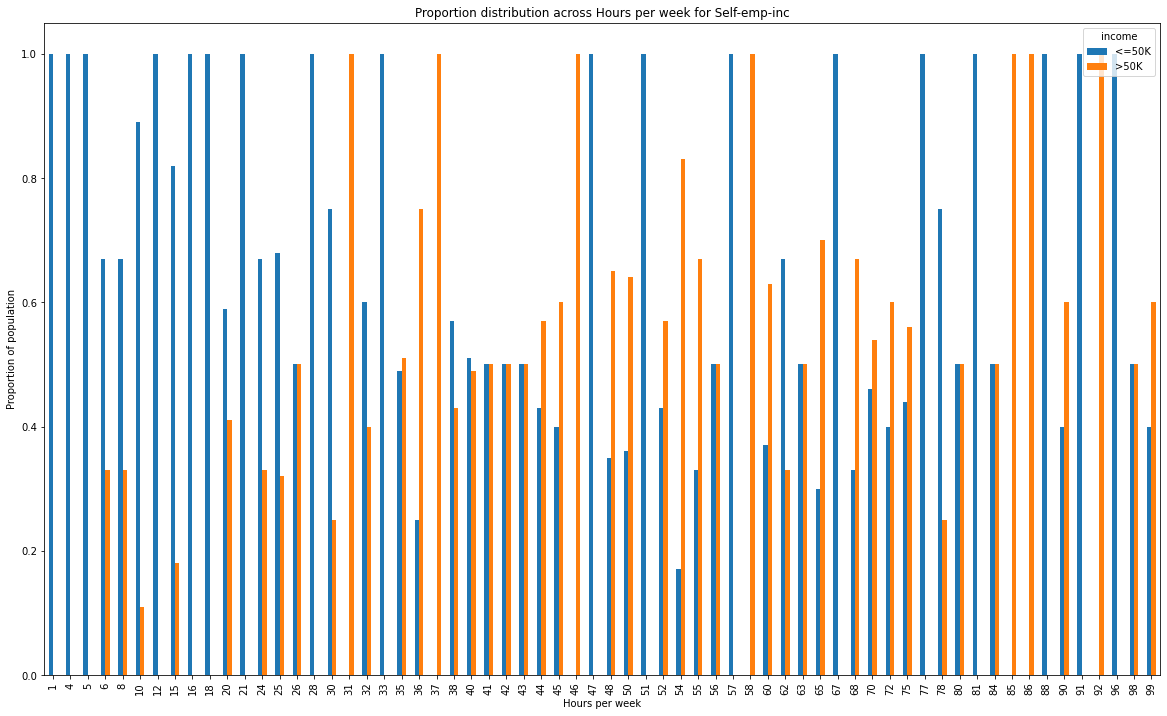

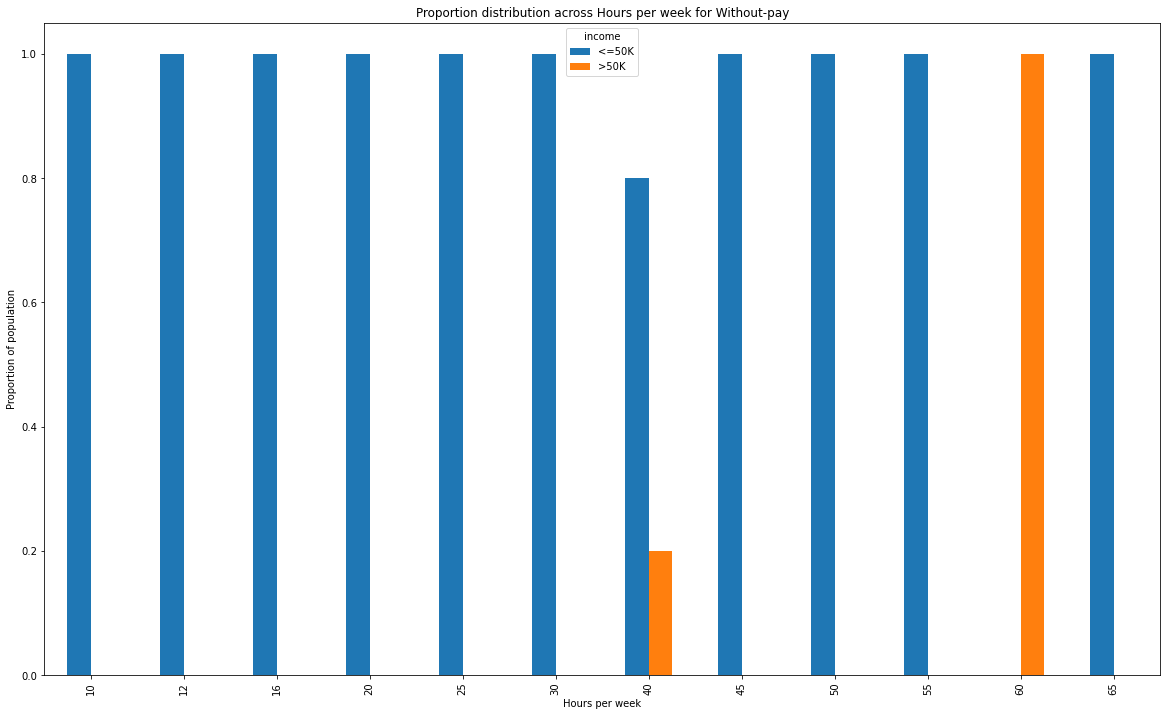

In [22]:
printmd('### 2.7.2 Hours worked across working classes')

for i in adult.workclass.unique():
    df = adult[adult.workclass == i]

    hours_per_week = round(pd.crosstab(df['hours.per.week'], df.income).div(pd.crosstab(df['hours.per.week'], df.income).apply(sum,1),0),2)
    # hours_per_week.sort_values(by = '>50K', inplace = True)
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week for '+ i, figsize = (20,12))
    ax.set_xlabel('Hours per week')
    ax.set_ylabel('Proportion of population')

    print()

In [23]:

# Remove education and fnlwgt
#adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')

* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

## Box plot

<AxesSubplot:>

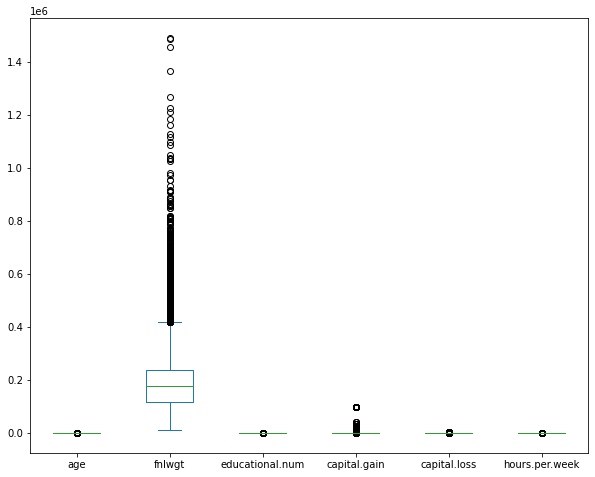

In [24]:
printmd('## Box plot')
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [25]:
printmd ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 

In [26]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')

In [27]:
# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, adult_label, test_size  = 0.2)

In [28]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data) 

In [29]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

In [30]:
#this part should be rewritten with our assignment, since i used pandas, but our assignments are using numpy

log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = model_eval(test_label, log_reg_pred)
print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),4)
display(ovl_logreg)

Logistic Regression : 85.58 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.8558,0.7515,0.5851,0.6579,0.5851,0.9399,0.1442


In [31]:
#Now the PCA starts
# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #training and testing data split

In [32]:
adult = adult.apply(LabelEncoder().fit_transform)
adult.head()

,age,workclass,fnlwgt,education,educational.num,marital.status,occupation,relationship,race,gender,capital.gain,capital.loss,hours.per.week,native.country,income,hour_worked_bins
0,8,3,19329,1,6,4,6,3,2,1,0,0,39,38,0,0
1,21,3,4212,11,8,2,4,0,4,1,0,0,49,38,0,0
2,11,1,25340,7,11,2,10,0,4,1,0,0,39,38,1,0
3,27,3,11201,15,9,2,6,0,2,1,98,0,39,38,1,0
4,1,2,5411,15,9,4,0,3,4,0,0,0,29,38,0,1


In [33]:
drop_elements = ['education', 'native.country']
y = adult["income"]
X = adult.drop(drop_elements, axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

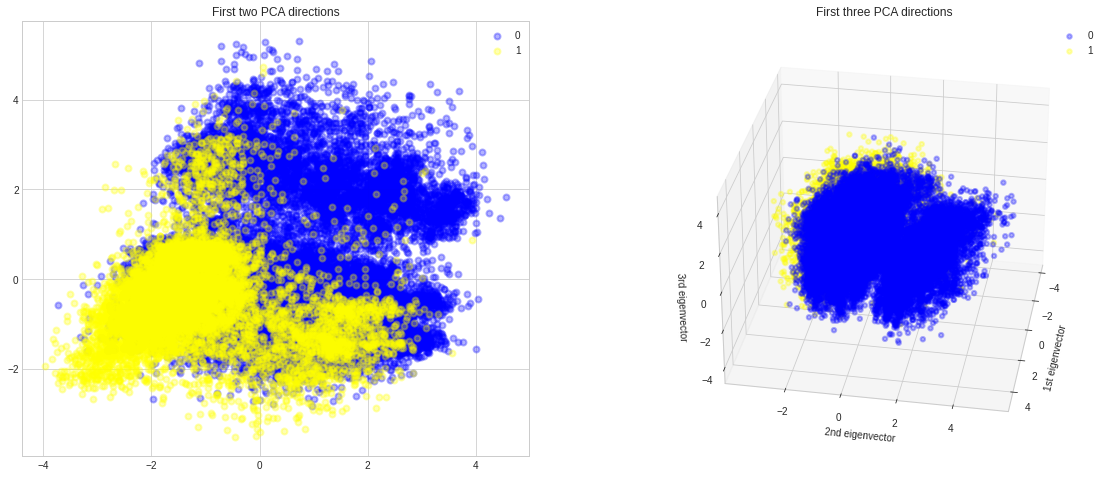

In [35]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
from sklearn.decomposition import PCA
std_scale = preprocessing.StandardScaler().fit(adult.drop('income', axis=1))
X = std_scale.transform(adult.drop('income', axis=1))
y = adult['income']

# Formatting
target_names = [0,1]
colors = ['blue','yellow','pink']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

In [36]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
pca = PCA(n_components=None)
x_train_pca = pca.fit_transform(X_train_std)
a = pca.explained_variance_ratio_
a_running = a.cumsum()
a_running

array([0.17594225, 0.26880607, 0.35165893, 0.43174053, 0.50673928,
       0.57746724, 0.64669821, 0.71423584, 0.77783529, 0.83273952,
       0.88639298, 0.93500172, 0.97265552, 1.        ])

In [37]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

The accuracy of the Logistic Regression is 0.7956802129184154


/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
# Random Forest Classifier
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
#y_pred = randomforest.predict(X_test)
score_randomforest = randomforest.score(X_test,y_test)
print('The accuracy of the Random Forest Model is', score_randomforest)

The accuracy of the Random Forest Model is 1.0


In [39]:
from sklearn.neighbors import KNeighborsClassifier #KNN
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
score_knn = knn.score(X_test,y_test)
print('The accuracy of the KNN Model is',score_knn)

The accuracy of the KNN Model is 0.7797113317637424


In [42]:
### cross validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
shuffle=True
kfold = KFold(n_splits=10, random_state=None) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','KNN','Random Forest']
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=9),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
models_dataframe

,CV Mean,Std
Logistic Regression,0.826133,0.002705
KNN,0.843209,0.003968
Random Forest,0.857643,0.003369
